In [1]:
import os
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight\notebooks
os.chdir('../')
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight

from NextPick.image_search import *
from NextPick.ImageDataset import ImageDataset
import plotly.express as px
import pickle
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

from annoy import AnnoyIndex
from geopy.geocoders import Nominatim
import config as cfg

C:\Users\chung\Documents\nextpick\notebooks
C:\Users\chung\Documents\nextpick


In [2]:
pkl_list = load_pkl_paths('data')
input_dataset = ImageDataset('data')
bs = 100
image_loader = torch.utils.data.DataLoader(input_dataset, batch_size=bs)
model, model_full = load_pretrained_model()

In [3]:
#pd_files = input_dataset.get_file_df()
with open('NextPick/pd_files.pkl','rb') as f:
    pd_files = pickle.load(f)
    f.close()

In [4]:
if os.path.exists(cfg.ANNOY_PATH):
    annoy_idx = AnnoyIndex(512, cfg.ANNOY_METRIC)
    annoy_idx.load(cfg.ANNOY_PATH)

In [5]:
test_img = 'notebooks/ski-test-img.png'
searches = eval_test_image(test_img, model, annoy_idx, 5)

In [6]:
def plot_input_and_similar(test_img, searches, pd, titles=None):
    '''
    Use this function instead of plot_similar.
    test_img: text path to test image
    searches: tuple of lists. index[0] is a list of similar indices. index[1] is a list of cosine distances (flat_list)
    pd: dataframe of paths
    '''
    idx = searches[0]
    titles = searches[1]
    
    f = plt.figure(figsize=(10,15))
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    rows = len(idx)
    cols = 2
    for i, img_idx in enumerate(idx):
        sp = f.add_subplot(rows, cols, 2*(i+1)) # want the output pictures on the right side
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        if titles is not None:
            sp.set_title('Cosine diff = %.3f'%titles[i], fontsize=16)
        data = Image.open(pd.iloc[img_idx].path, 'r')
        data = data.convert('RGB')
        data = data.resize((400,300), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    
    #plot test image
    sp = f.add_subplot(rows, cols, rows) # want the test image in the middle of the column
    sp.axis('Off')
    sp.get_xaxis().set_visible(False)
    sp.get_yaxis().set_visible(False)
    sp.set_title('User Input', fontsize=16)
    data = Image.open(test_img, 'r')
    data = data.convert('RGB')
    data = data.resize((400,300), Image.ANTIALIAS)
    plt.imshow(data)
    plt.tight_layout()
        
    plt.autoscale(tight=True)
#     if fig_title is not None:
#         plt.suptitle(titles, size=32)
#         f.tight_layout()
#         f.subplots_adjust(top=0.94)
#         plt.show()

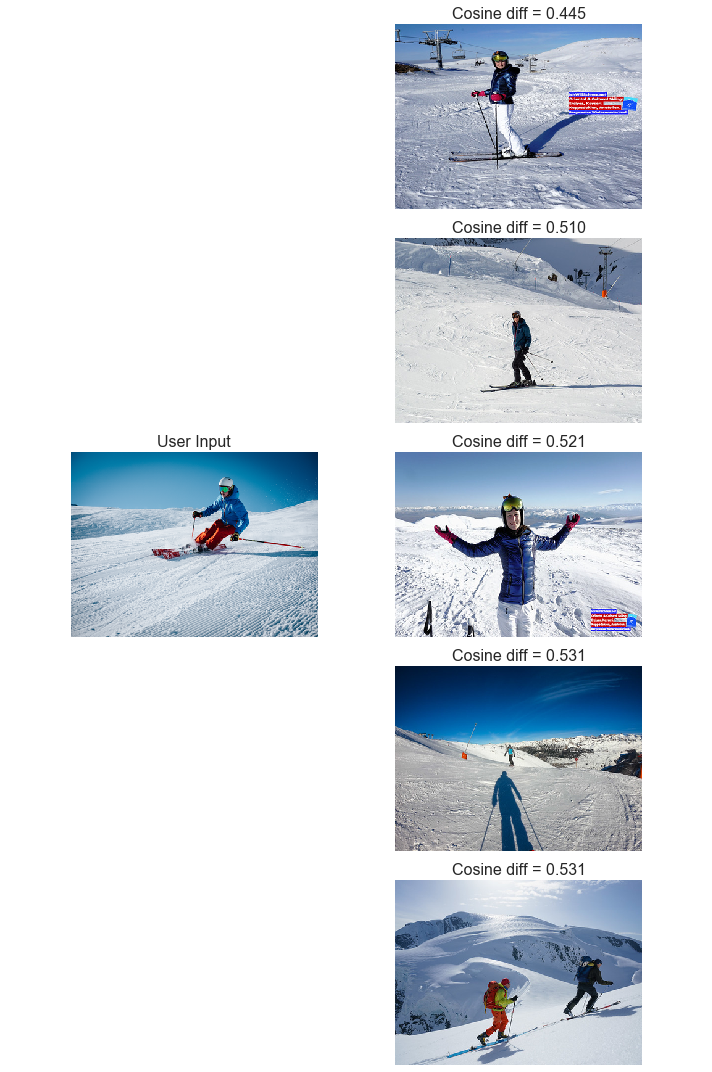

In [7]:
plot_input_and_similar(test_img, searches, pd_files)

In [8]:
def plot_map(searches):
    
    idx = searches[0] #list of annoy index results
    class_labels = list(pd_files.iloc[idx].label.drop_duplicates())
    name = list(pd_files.iloc[idx]['name'].str.rstrip('.jpg')) # list of photo id's
    
    for_plotly = pd.DataFrame(columns=['latitude','longitude'])
    for label in class_labels:
        with open('data/%s/%s.pkl'%(label,label), 'rb') as f:
            locations = pickle.load(f)
            for_plotly = pd.concat([locations.loc[locations['id'].isin(name)][['latitude','longitude']],for_plotly])
            f.close()
    for_plotly = for_plotly.reset_index(drop=True)
    keys_for_display = ['country']
    gl = Nominatim(user_agent='default')
    for_plotly['latlon'] = list(zip(for_plotly['latitude'],for_plotly['longitude']))   
    locations = []
    display_names = []
    for i, row in for_plotly.iterrows():
        location = gl.reverse(for_plotly.iloc[i]['latlon'])
        locations.append(location.address)
        display_names.append(str(i+1))
#         display_names.append(", ".join([location.raw['address'][key] for key in keys_for_display]))
#         locations.append(gl.reverse(for_plotly.iloc[i]['latlon']))
#     addresses = [", ".join([location.raw['address'][key] for key in keys_for_address]) for location in locations]  
    for_plotly['address'] = locations
    for_plotly['display'] = display_names
    print(for_plotly)

    fig = px.scatter_geo(for_plotly, lat='latitude', lon='longitude', text='display')
    
    fig.update_traces(textposition="top center",
                      mode='markers+text')
    fig.show()

In [9]:
plot_map(searches)

    latitude  longitude                  latlon  \
0  69.473329  19.891433  (69.473329, 19.891433)   
1  44.585163   6.655455   (44.585163, 6.655455)   
2  46.777266   8.378100   (46.777266, 8.378100)   
3  38.540713  35.518884  (38.540713, 35.518884)   
4  38.546587  35.515086  (38.546587, 35.515086)   

                                             address display  
0                   Lyngen, Troms og Finnmark, Norge       1  
1  Mayt V5, Vallon, Les Florins, Risoul, Briançon...       2  
2  Engstlen-Jochpass, Engstlenalp, Innertkirchen,...       3  
3  Hisarcık Erciyes Mahallesi, Melikgazi, Kayseri...       4  
4  Hisarcık Kapı, Hisarcık Erciyes Mahallesi, Mel...       5  


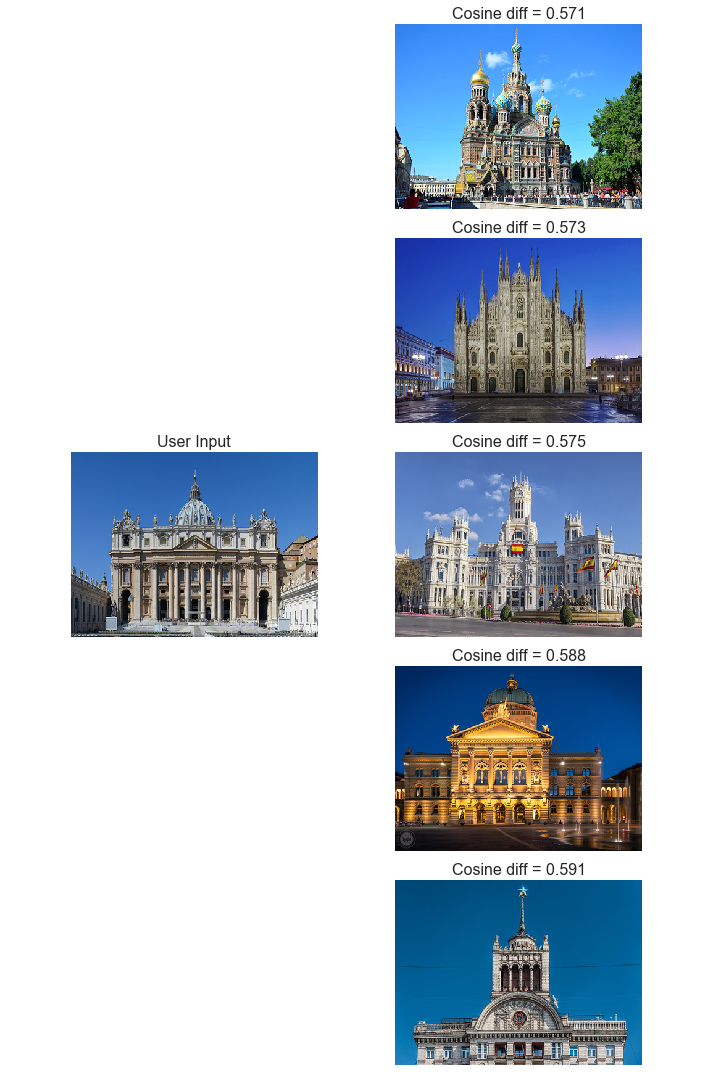

In [10]:
test_img2 = 'notebooks/vatican.jpg'
searches2 = eval_test_image(test_img2, model, annoy_idx)
plot_input_and_similar(test_img2, searches2, pd_files)

In [11]:
plot_map(searches2)

    latitude  longitude                  latlon  \
0  50.445077  30.519208  (50.445077, 30.519208)   
1  46.947285   7.443932   (46.947285, 7.443932)   
2  40.419207  -3.692371  (40.419207, -3.692371)   
3  45.464299   9.190449   (45.464299, 9.190449)   
4  59.939444  30.328155  (59.939444, 30.328155)   

                                             address display  
0  Нафтогаз України, 13/6, Богдана Хмельницького ...       1  
1  Bundesplatz, Amthausgasse, Gelbes Quartier, St...       2  
2  Calle de Alcalá, Jerónimos, Retiro, Madrid, Ár...       3  
3  Duomo di Milano, Piazza del Duomo, Duomo, Muni...       4  
4  набережная канала Грибоедова, Дворцовый округ,...       5  


In [12]:
def create_df_for_map_plot(searches, pd_files):
    '''
    :param searches: search results from evalTestImage()
    :param pd_files: pandas DataFrame from ImageDataset.get_file_df()
    :return: DataFrame of the searches' location and address
    '''
    idx = searches[0]  # list of annoy index results
    labels = pd_files.iloc[idx].label
    class_labels = list(labels.drop_duplicates()) 
    name = list(pd_files.iloc[idx]['name'].str.rstrip('.jpg'))  # list of photo id's

    for_plotly = pd.DataFrame(columns=['latitude', 'longitude'])
    for label in class_labels:
        with open('data/%s/%s.pkl' % (label, label), 'rb') as f:
            locations = pickle.load(f)
            for_plotly = pd.concat(
                [locations.loc[locations['id'].isin(name)][['latitude', 'longitude']], for_plotly])
            f.close()

    for_plotly['paths'] = list(pd_files.iloc[idx]['sub_paths'])
    for_plotly['paths'] = for_plotly['paths'].str.replace('\\','/')
    for_plotly['labels'] = list(labels)
    for_plotly['cos_diff'] = np.around(searches[1], 3)
    for_plotly = for_plotly.reset_index(drop=True)
    gl = Nominatim(user_agent='default')
    for_plotly['latlon'] = list(zip(for_plotly['latitude'], for_plotly['longitude'])) # for GeoPy reverse method
    for_plotly['address'] = for_plotly['latlon'].apply(gl.reverse)

    return for_plotly

In [13]:
searches = eval_test_image(test_img, model, annoy_idx, 40)
df1 = create_df_for_map_plot(searches, pd_files)

In [14]:
df1.head()

latitude   longitude                        paths      labels  cos_diff  \
0  41.882718  -87.623863  /ski resort/49788543373.jpg  ski resort     0.445   
1  37.746828   14.948272   /ski slope/49455542272.jpg   ski slope     0.510   
2  52.485064   13.300613  /ski resort/49788543528.jpg  ski resort     0.521   
3  52.485064   13.300613   /ski slope/49458494093.jpg   ski slope     0.531   
4  42.812880   -0.423856    /crevasse/33853719818.jpg    crevasse     0.531   

                    latlon                                            address  
0  (41.882718, -87.623863)  (McCormick Tribune Ice Rink, McCormick Tribune...  
1   (37.746828, 14.948272)  (Sentiero 708 Monte Fornello, Bronte, Catania,...  
2   (52.485064, 13.300613)  (Horst-Dohm-Eisstadion, 9, Fritz-Wildung-Straß...  
3   (52.485064, 13.300613)  (Horst-Dohm-Eisstadion, 9, Fritz-Wildung-Straß...  
4   (42.812880, -0.423856)  (Chemin d'Anéou à Pombie, Laruns, Oloron-Saint...

In [15]:
df1.address[4]

Location(Chemin d'Anéou à Pombie, Laruns, Oloron-Sainte-Marie, Pyrénées-Atlantiques, Nouvelle-Aquitaine, France métropolitaine, 64440, France, (42.8147112, -0.4218324, 0.0))

In [16]:
img_idx = searches[0]
pd_files.iloc[img_idx[4]].path

'C:/Users/chung/Documents/04-Insight/insight/NextPick-app/NextPick/data\\crevasse\\33853719818.jpg'

In [17]:
from NextPick.plotly_map import create_plot, get_input_latlon, get_distances, get_top5_distance
input_latlon = get_input_latlon("Toronto, Canada")
df = get_distances(input_latlon, df1)
df = get_top5_distance(df, "near")

...Ascending


In [18]:
df

latitude    longitude                        paths      labels  cos_diff  \
0  41.882718   -87.623863  /ski resort/49788543373.jpg  ski resort     0.445   
1  37.706137  -119.614419   /ski slope/49458496608.jpg   ski slope     0.552   
2  37.706137  -119.614419   /ski slope/49458493663.jpg   ski slope     0.561   
3  63.009496  -151.222686   /ski slope/49455542432.jpg   ski slope     0.612   
4  62.966975  -151.170503   /ski slope/49458970566.jpg   ski slope     0.620   

                     latlon  \
0   (41.882718, -87.623863)   
1  (37.706137, -119.614419)   
2  (37.706137, -119.614419)   
3  (63.009496, -151.222686)   
4  (62.966975, -151.170503)   

                                             address    dist  display  
0  (McCormick Tribune Ice Rink, McCormick Tribune...   702.0  Image 1  
1  (Mariposa County, California, United States of...  3430.0  Image 2  
2  (Mariposa County, California, United States of...  3430.0  Image 3  
3  (Denali, Alaska, United States of America, (63...  4923.0  Image 4  
4  (Basecamp, Denali, Alaska, United States of Am...  4922.0  Image 5

In [19]:
def plot_input_and_similar_sorted(test_img, df):
    '''
    Use this function instead of plot_similar.
    test_img: text path to test image
    searches: tuple of lists. index[0] is a list of similar indices. index[1] is a list of cosine distances (flat_list)
    pd: dataframe of paths
    '''
    
    f = plt.figure(figsize=(10,15))
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    rows = len(df.index)
    cols = 2
    for i, row in df.iterrows():
        sp = f.add_subplot(rows, cols, 2*(i+1)) # want the output pictures on the right side
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        data = Image.open("{}/data/{}".format(os.getcwd(),df.iloc[i]['paths']), 'r')
        data = data.convert('RGB')
        data = data.resize((400,300), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    
    #plot test image
    sp = f.add_subplot(rows, cols, rows) # want the test image in the middle of the column
    sp.axis('Off')
    sp.get_xaxis().set_visible(False)
    sp.get_yaxis().set_visible(False)
    sp.set_title('User Input', fontsize=16)
    data = Image.open(test_img, 'r')
    data = data.convert('RGB')
    data = data.resize((400,300), Image.ANTIALIAS)
    plt.imshow(data)
    plt.tight_layout()
        
    plt.autoscale(tight=True)
#     if fig_title is not None:
#         plt.suptitle(titles, size=32)
#         f.tight_layout()
#         f.subplots_adjust(top=0.94)
#         plt.show()

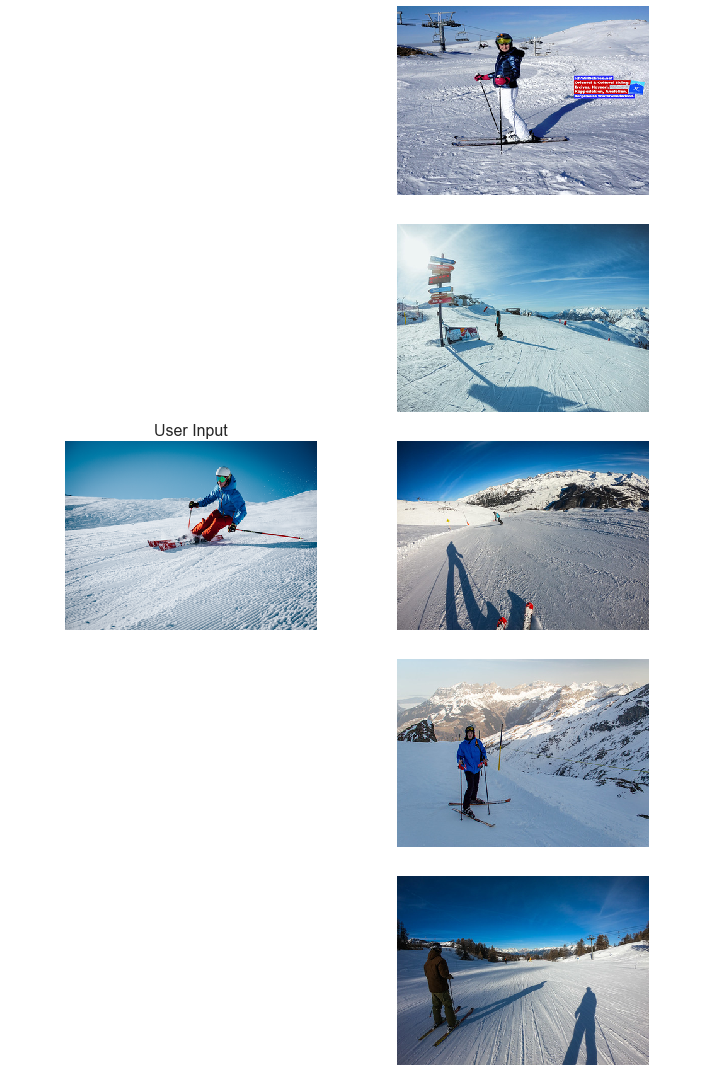

In [20]:
plot_input_and_similar_sorted(test_img, df)

In [37]:
searches2 = eval_test_image(test_img2, model, annoy_idx, 40)
df2 = create_df_for_map_plot(searches2, pd_files)

In [38]:
df2 = get_distances(input_latlon, df2)
df2

latitude    longitude                                paths  \
0    48.856018     2.335109           /cathedral/49519902321.jpg   
1    50.822285    -0.137479            /basilica/49881734098.jpg   
2    48.191668    16.380829              /church/31970333776.jpg   
3    41.469074     2.065429               /plaza/49666856386.jpg   
4    45.452032  -121.130640            /fountain/49575735383.jpg   
5   -13.516773   -71.978774  /apartment building/49837167016.jpg   
6    51.381624    -2.358562            /basilica/49644348163.jpg   
7    46.207900     6.147515                 /dam/49717340388.jpg   
8    57.034472    34.956768            /basilica/49888906927.jpg   
9    48.141012    11.578989            /fountain/49546058682.jpg   
10   40.417155    -3.714838               /plaza/49628708118.jpg   
11   48.861496     2.337169            /fountain/49573946807.jpg   
12   48.141012    11.578989              /market/49867895872.jpg   
13   39.549397    -8.980206           /courthouse/7009832553.jpg   
14   39.547858    -8.981109           /monastery/49652081197.jpg   
15   38.212987   -84.249746            /basilica/49882514888.jpg   
16   40.835866    14.248194           /courtyard/49963437267.jpg   
17   40.835908    14.248409           /monastery/49736125302.jpg   
18   52.373156     4.892735           /courtyard/49922827762.jpg   
19   52.373097     4.893089                 /inn/49922827762.jpg   
20   52.373352     4.892045           /cathedral/49472508907.jpg   
21   50.445077    30.519208            /fountain/49881916353.jpg   
22   45.071058     7.684786            /fountain/49882752357.jpg   
23   45.071550     7.684936            /fountain/49784867746.jpg   
24   41.147129    -8.615823            /basilica/49887423082.jpg   
25   46.947285     7.443932               /plaza/49845515133.jpg   
26   43.709122    10.405297              /temple/49584101492.jpg   
27   34.147694  -118.142895           /cathedral/49710433783.jpg   
28   37.377557    -5.985724           /mausoleum/49816964902.jpg   
29   40.419207    -3.692371               /abbey/49775584268.jpg   
30   37.372032    -5.988020     /building facade/15573446948.jpg   
31   45.464299     9.190449            /courtyard/5781941734.jpg   
32   41.896008    12.474288              /market/49877790532.jpg   
33   35.909580    14.426047            /hospital/49773930278.jpg   
34   48.886250     2.343113              /palace/49553692322.jpg   
35   45.703916     9.662733             /pavilion/6277079367.jpg   
36   43.769001    11.261308     /building facade/49369277988.jpg   
37   41.384351     2.176108               /butte/49679471053.jpg   
38   59.939444    30.328155                 /dam/49674031036.jpg   
39   36.891030    15.070849                 /dam/49832889847.jpg   

                labels  cos_diff                    latlon  \
0            cathedral     0.571     (48.856018, 2.335109)   
1             basilica     0.573    (50.822285, -0.137479)   
2               church     0.573    (48.191668, 16.380829)   
3                plaza     0.575     (41.469074, 2.065429)   
4             fountain     0.588  (45.452032, -121.130640)   
5   apartment building     0.591  (-13.516773, -71.978774)   
6             basilica     0.599    (51.381624, -2.358562)   
7                  dam     0.602     (46.207900, 6.147515)   
8             basilica     0.606    (57.034472, 34.956768)   
9             fountain     0.609    (48.141012, 11.578989)   
10               plaza     0.615    (40.417155, -3.714838)   
11            fountain     0.618     (48.861496, 2.337169)   
12              market     0.623    (48.141012, 11.578989)   
13          courthouse     0.632    (39.549397, -8.980206)   
14           monastery     0.638    (39.547858, -8.981109)   
15            basilica     0.640   (38.212987, -84.249746)   
16           courtyard     0.644    (40.835866, 14.248194)   
17           monastery     0.645    (40.835908, 14.248409)   
18           courtyard     0.647     (5

In [39]:
df2 = get_top5_distance(df2, "far")

...Descending


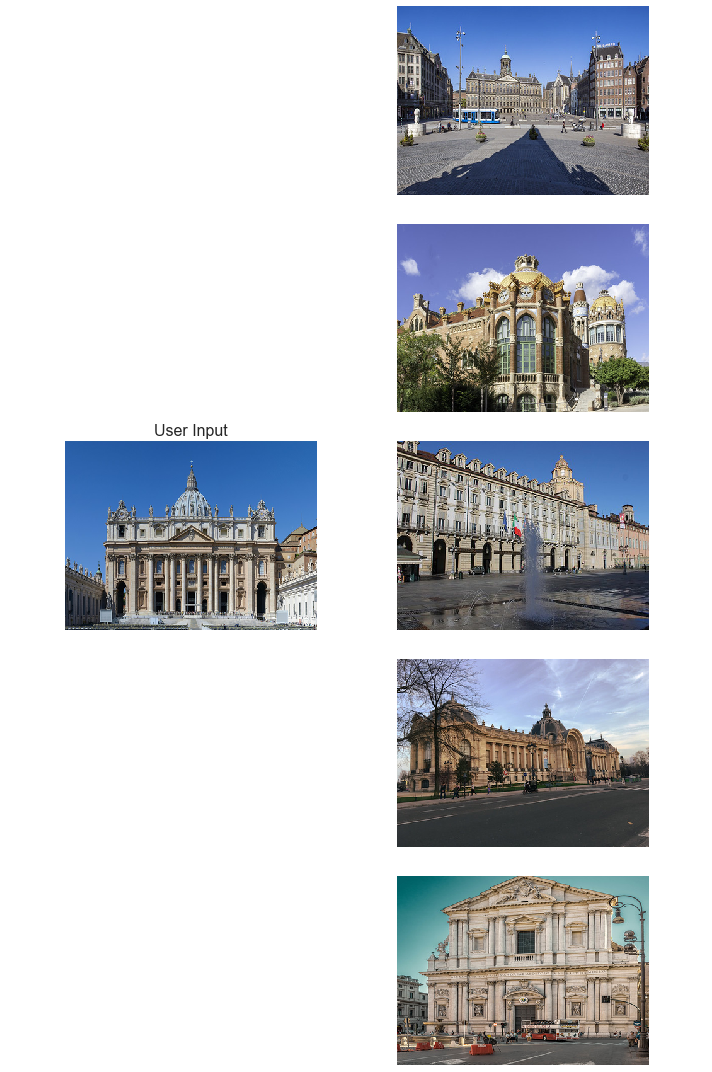

In [40]:
plot_input_and_similar_sorted(test_img2, df2)

In [41]:
df2

latitude  longitude                       paths     labels  cos_diff  \
0  36.891030  15.070849        /dam/49832889847.jpg        dam     0.692   
1  35.909580  14.426047   /hospital/49773930278.jpg   hospital     0.687   
2  50.445077  30.519208   /fountain/49881916353.jpg   fountain     0.653   
3  40.835866  14.248194  /courtyard/49963437267.jpg  courtyard     0.644   
4  57.034472  34.956768   /basilica/49888906927.jpg   basilica     0.606   

                   latlon                                            address  \
0  (36.891030, 15.070849)  (Palazzo Ducezio, Via Monsignor Salvatore Nico...   
1  (35.909580, 14.426047)  (Il-Mosta, Malta, (35.90967535, 14.42565850614...   
2  (50.445077, 30.519208)  (Нафтогаз України, 13/6, Богдана Хмельницького...   
3  (40.835866, 14.248194)  (Piazza del Plebiscito, Municipalità 1, Napoli...   
4  (57.034472, 34.956768)  (Церковь Спаса Нерукотворного Образа, Старицка...   

     dist  display  
0  7615.0  Image 1  
1  7639.0  Image 2  
2  7577.0  Image 3  
3  7288.0  Image 4  
4  7289.0  Image 5